### This script is comparing different ES cell engineering methods in the CM Pilot2 
* sample: WTC11 lenti, WTC11 PB, WTC11 recombinase (new design), H9 lenti, H9 PB, H9 inducible 
* sgrna lib: CM Pilot2 
* split into promoter and enhancer 
* focus on the union hits 

In [1]:
import os
import re
import sys
import collections
import argparse
import tables
import itertools
import matplotlib
import numba

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

In [2]:
def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels, fontsize=14, color='#000000')
    ax.set_xlim(0.25, len(labels) + 0.75)

In [4]:
DIR = '/project/GCRB/Hon_lab/s426305/Analysis/IGVF/'
WTC11_lenti = DIR + '20240611_WTC11_lenti_CMPilot2_reprocss/pySpade/'
WTC11_PB = DIR + '20240605_WTC11_CMPilot2_PB9/pySpade/'
WTC11_recomb = DIR + '20241022_WTC11_recombinase_CMPilot2/pySpade/'
H9_lenti = DIR + '20240723_H9_lenti_CMPilot2_reprocess/pySpade/'
H9_PB = DIR + '20240605_H9_CMPilot2_PB9/pySpade/'
H9_inducible = DIR + '20240605_H9_CMPilot2_inducible/pySpade/'

In [5]:
local_hit_file = 'filtered_local.csv'
WTC11_lenti_enh = pd.read_csv(WTC11_lenti + local_hit_file, index_col=0)
WTC11_PB_enh = pd.read_csv(WTC11_PB + local_hit_file, index_col=0)
WTC11_recomb_enh = pd.read_csv(WTC11_recomb + local_hit_file, index_col=0)
H9_lenti_enh = pd.read_csv(H9_lenti + local_hit_file, index_col=0)
H9_PB_enh = pd.read_csv(H9_PB + local_hit_file, index_col=0)
H9_inducible_enh = pd.read_csv(H9_inducible + local_hit_file, index_col=0)

In [6]:
annot_dict_file = '/project/GCRB/Hon_lab/s426305/Analysis/IGVF/20231027_CMPilot2_lenti_cleancell/pySpade/perturbation_region_annot.txt'
annot_dict = {}
with open(annot_dict_file) as f:
    for line in f:
        region_id, annotation = line.strip().split("\t")
        annot_dict.update({region_id : annotation})

In [14]:
#uniflter_df 
un_WTC11_lenti = pd.read_csv(WTC11_lenti + 'WTC11_CMPilot2_lenti_local_v1.csv', index_col=0)
un_WTC11_PB = pd.read_csv(WTC11_PB + 'WTC11_CMPilot2_PB9_local.csv', index_col=0)
un_WTC11_recomb = pd.read_csv(WTC11_recomb + 'unfiltered_local_df.csv', index_col=0)
un_H9_lenti = pd.read_csv(H9_lenti + 'H9_lenti_CMPilot2_local.csv', index_col=0)
un_H9_PB = pd.read_csv(H9_PB + 'H9_CMPilot2_PB9_local.csv', index_col=0)
un_H9_inducible = pd.read_csv(H9_inducible + 'H9_CMPilot2_inducible_local.csv', index_col=0)

### format data

In [7]:
WTC11_lenti_enh['combined'] = WTC11_lenti_enh['gene_names'] + '_' + WTC11_lenti_enh['region']
WTC11_PB_enh['combined'] = WTC11_PB_enh['gene_names'] + '_' + WTC11_PB_enh['region']
WTC11_recomb_enh['combined'] = WTC11_recomb_enh['gene_names'] + '_' + WTC11_recomb_enh['region']
H9_lenti_enh['combined'] = H9_lenti_enh['gene_names'] + '_' + H9_lenti_enh['region']
H9_PB_enh['combined'] = H9_PB_enh['gene_names'] + '_' + H9_PB_enh['region']
H9_inducible_enh['combined'] = H9_inducible_enh['gene_names'] + '_' + H9_inducible_enh['region']

In [9]:
all_local_hits_region = list(set(WTC11_lenti_enh['combined']).union(set(WTC11_PB_enh['combined']).union(set(WTC11_recomb_enh['combined']).union(set(H9_lenti_enh['combined']).union(set(H9_PB_enh['combined']).union(H9_inducible_enh['combined']))))))

In [10]:
len(all_local_hits_region)

97

In [15]:
un_WTC11_lenti['combined'] = un_WTC11_lenti['gene_names'] + '_' + un_WTC11_lenti['region']
un_WTC11_PB['combined'] = un_WTC11_PB['gene_names'] + '_' + un_WTC11_PB['region']
un_WTC11_recomb['combined'] = un_WTC11_recomb['gene_names'] + '_' + un_WTC11_recomb['region']
un_H9_lenti['combined'] = un_H9_lenti['gene_names'] + '_' + un_H9_lenti['region']
un_H9_PB['combined'] = un_H9_PB['gene_names'] + '_' + un_H9_PB['region']
un_H9_inducible['combined'] = un_H9_inducible['gene_names'] + '_' + un_H9_inducible['region']

### enhancer repression and visualization 

In [33]:
A = [] 
B = []
C = []
D = []
E = []
F = []

for hits in all_local_hits_region:
    a, _ = un_WTC11_lenti[un_WTC11_lenti['combined'] == hits].shape
    b, _ = un_WTC11_PB[un_WTC11_PB['combined'] == hits].shape
    c, _ = un_WTC11_recomb[un_WTC11_recomb['combined'] == hits].shape
    d, _ = un_H9_lenti[un_H9_lenti['combined'] == hits].shape
    e, _ = un_H9_PB[un_H9_PB['combined'] == hits].shape
    f, _ = un_H9_inducible[un_H9_inducible['combined'] == hits].shape
    if (a==0) or (b==0) or (c==0) or (d==0) or (e==0) or (f==0):
        print(hits)
        continue
    else:
        a_val = un_WTC11_lenti[un_WTC11_lenti['combined'] == hits]['fc'].values[0]
        b_val = un_WTC11_PB[un_WTC11_PB['combined'] == hits]['fc'].values[0]
        c_val = un_WTC11_recomb[un_WTC11_recomb['combined'] == hits]['fc'].values[0]
        d_val = un_H9_lenti[un_H9_lenti['combined'] == hits]['fc'].values[0]
        e_val = un_H9_PB[un_H9_PB['combined'] == hits]['fc'].values[0]
        f_val = un_H9_inducible[un_H9_inducible['combined'] == hits]['fc'].values[0]
        A.append(a_val)
        B.append(b_val)
        C.append(c_val)
        D.append(d_val)
        E.append(e_val)
        F.append(f_val)

In [22]:
all_local_hits_region.remove('AC084125.4_chr8:144500907-144501407')
all_local_hits_region.remove('SOX17_chr8:54457434-54458434')
all_local_hits_region.remove('NR5A2_chr1:201377200-201378200')
all_local_hits_region.remove('B3GNT8_chr19:41427183-41427682')
all_local_hits_region.remove('GRHL2_chr8:101491939-101492939')

In [23]:
label_list = []
for name in all_local_hits_region:
    gene = name.split('_')[0]
    region = name.split('_')[1]
    annot = annot_dict[region]
    if len(annot.split('_')) < 2:
        label = gene + '_enhancer'
        label_list.append(label)
    else:
        if annot.split('_')[1].startswith('PROM'):
            pred_gene = annot.split('_')[0]
            if gene == pred_gene:
                label = gene +'_promoter'
            else:
                label = gene + '_enhancer'
        elif annot.split('_')[1].startswith('ENH'):
            label = gene + '_enhancer'
        else:
            label = gene + '_enhancer'
        label_list.append(label)

In [27]:
promoter_index = []
enhancer_index = []
for index, label in enumerate(label_list):
    if label.split('_')[1] == 'promoter':
        promoter_index.append(index)
    else:
        enhancer_index.append(index)

In [28]:
print(len(all_local_hits_region))
print(len(label_list))

92
92


In [30]:
len(enhancer_index)

31

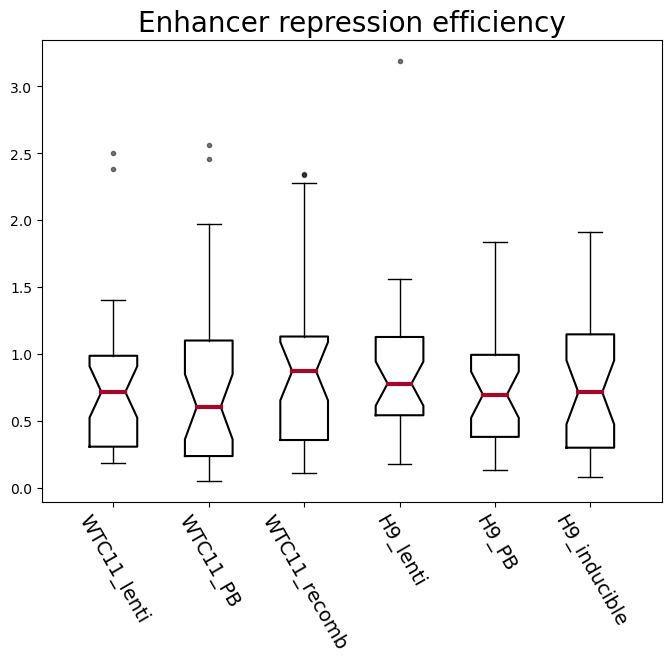

In [36]:
fig, ax = plt.subplots(figsize= (8,6))
ax.set_title('Enhancer repression efficiency', fontsize=20)
#ax.set_ylim(-0.1, 1.1)
flierprops = dict(marker='o', markerfacecolor='#000000', markersize=3, alpha=0.5,
                    linestyle='none')
medianprops = dict(linestyle='-', linewidth=3, color='#A60628')
boxprops = dict(linestyle='-', linewidth=1.5)
    
ax.boxplot([np.array(A)[enhancer_index],
            np.array(B)[enhancer_index],
            np.array(C)[enhancer_index],
            np.array(D)[enhancer_index],
            np.array(E)[enhancer_index],
            np.array(F)[enhancer_index],],
            showfliers=True, notch=True, flierprops=flierprops, medianprops=medianprops, boxprops=boxprops)

labels = ['WTC11_lenti', 'WTC11_PB', 'WTC11_recomb', 'H9_lenti', 'H9_PB', 'H9_inducible']
set_axis_style(ax, labels)
plt.xticks(rotation=-60)
#plt.show()
plt.savefig('./Enhancer_repression_20241114.pdf', bbox_inches='tight')

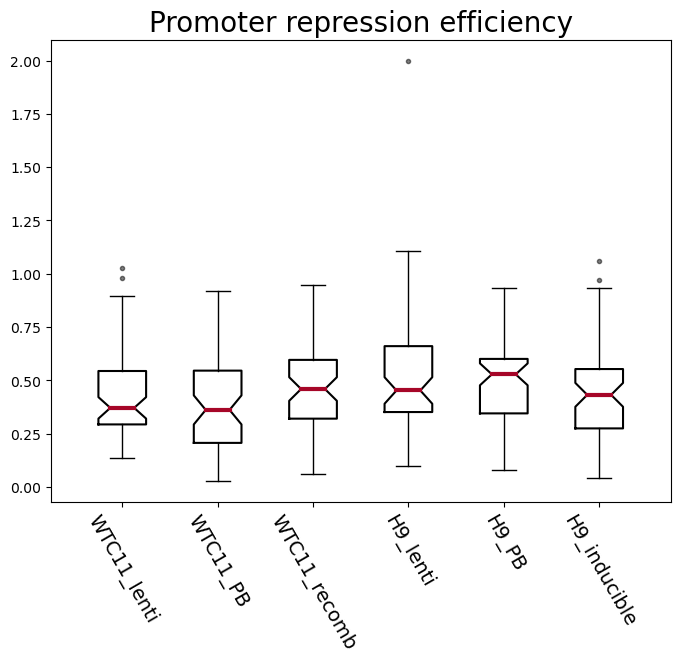

In [37]:
fig, ax = plt.subplots(figsize= (8,6))
ax.set_title('Promoter repression efficiency', fontsize=20)
#ax.set_ylim(-0.1, 1.1)
flierprops = dict(marker='o', markerfacecolor='#000000', markersize=3, alpha=0.5,
                    linestyle='none')
medianprops = dict(linestyle='-', linewidth=3, color='#A60628')
boxprops = dict(linestyle='-', linewidth=1.5)
    
ax.boxplot([np.array(A)[promoter_index],
            np.array(B)[promoter_index],
            np.array(C)[promoter_index],
            np.array(D)[promoter_index],
            np.array(E)[promoter_index],
            np.array(F)[promoter_index],],
            showfliers=True, notch=True, flierprops=flierprops, medianprops=medianprops, boxprops=boxprops)

labels = ['WTC11_lenti', 'WTC11_PB', 'WTC11_recomb', 'H9_lenti', 'H9_PB', 'H9_inducible']
set_axis_style(ax, labels)
plt.xticks(rotation=-60)
#plt.show()
plt.savefig('./Promoter_repression_20241114.pdf', bbox_inches='tight')